In [1]:
from common import *
from helpers import *
import json
import logging
import os
import itertools
import numpy as np

logger = logging.getLogger(__name__)
logging.basicConfig(level=os.environ.get("LOGLEVEL", "WARNING"))

RK Toolkit 0.0.1b


### Preprocessing

In [2]:
data = make_df_from_sheet("data/Sales Data Dendogram.xlsx")
df = preprocess(data)
df.head(n=10)

,order_id,total_sales,discount,total_quantity,total_profit,postal_code,cateogry_embedding,subcategory_embedding,returns,ship_mode_embedding,country,state,region,city
0,CA-2014-100006,377.970,0.0,3,109.6113,10024,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",0,"[0, 0, 0, 1]",United States,New York,East,New York City
1,CA-2014-100090,699.192,0.4,9,-19.0890,94122,"[1, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0, 0, 0, 2]",United States,California,West,San Francisco
2,CA-2014-100293,91.056,0.2,6,31.8696,32216,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,"[0, 0, 0, 1]",United States,Florida,South,Jacksonville
3,CA-2014-100328,3.928,0.2,1,1.3257,10024,"[0, 1, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0, 0, 0, 1]",United States,New York,East,New York City
4,CA-2014-100363,21.376,0.4,5,7.7192,85301,"[0, 2, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...",0,"[0, 0, 0, 2]",United States,Arizona,West,Glendale
5,CA-2014-100391,14.620,0.0,2,6.7252,10035,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0,"[0, 0, 0, 1]",United States,New York,East,New York City
6,CA-2014-100678,697.074,0.9,11,61.7937,77095,"[1, 2, 1]","[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0,"[0, 0, 0, 4]",United States,Texas,Central,Houston
7,CA-2014-100706,129.440,0.0,8,17.7202,22153,"[1, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[0, 0, 2, 0]",United States,Virginia,South,Springfield
8,CA-2014-100762,508.620,0.0,11,219.0774,49201,"[0, 4, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, ...",0,"[0, 0, 0, 4]",United States,Michigan,Central,Jackson
9,CA-2014-100860,18.750,0.0,5,9.0000,91767,"[0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,"[0, 0, 1, 0]",United States,California,West,Pomona


In [3]:
numeric_columns=["total_sales", "discount", "total_quantity", "total_profit", "returns"]
from sklearn.preprocessing import MinMaxScaler
df[numeric_columns] = MinMaxScaler().fit_transform(df[numeric_columns])
if "postal_code" in df:
    del df["postal_code"]

### Embed Row Into Ontological Heirarchy

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Average similarity of graphs pre filter: 1.0


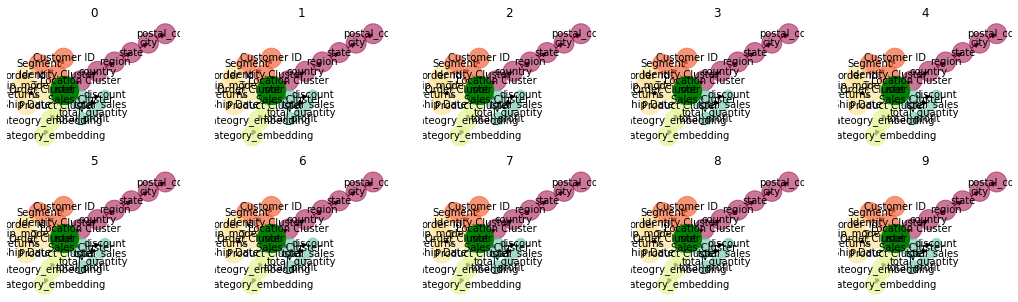

In [4]:
hmap = json.load(open("data/heirarchy2.json", "r"))
hft = BaseOntologyTransform(mapping=hmap)
mdist = mahalanobis(df[numeric_columns], df[numeric_columns])
mdist = (mdist - mdist.min()) / (mdist.max() - mdist.min())

graphs = []
for i, row in df.iterrows():
    g = hft.transform(row)
    g.id = i
    graphs.append(g)
    if i > 10:
        break
        
distances = compute_distances(graphs, mdist, np.array([1, 0]))
visualize_10(graphs)

print("Average similarity of graphs pre filter: {}".format(1 - np.mean(distances)))

### Build Untuned R-K Pipeline

In [5]:
import numbers

class SimpleChildLinker():
    
    def __init__(self, theta=1):
        self.theta = theta
        
    def get_knobs(self):
        return {"theta": self.theta}
    
    def set_knob(self, knb, v):
        if knb == "theta":
            self.theta = v
        else:
            raise ValueError("No knob {}".format(knb))
   
    def check_valid_node(self, node) -> bool:
        if "value" not in node:
            return False   
        if not isinstance(node["value"], numbers.Number):
            return False
        return True
    
    def link(self, G):
        gC = copy.deepcopy(G)
        for n in G.nodes:
            for p in itertools.combinations(G.get_children(n), 2):
                if len(p) < 2:
                    continue
                if not self.check_valid_node(G.nodes[p[0]]) or not self.check_valid_node(G.nodes[p[1]]):
                    continue  
                u_v, v_v = G.nodes[p[0]]["value"], G.nodes[p[1]]["value"]
                d = np.linalg.norm(u_v - v_v)
                if d < self.theta:
                    fn = 0 if u_v < v_v else 1
                    tn = 1 ^ fn  
                    gC.add_edge(Edge(u=p[fn], v=p[tn], attributes={"edge_distance": d}))
        return gC

In [6]:
filters, linkers = {}, {}
for k, v in graphs[0].nodes.items():
    if 'value' in v and isinstance(v['value'], numbers.Number):
        filters[k] = RangeFilter(min=df[k].min(), max=df[k].max())        
linkers['root'] = SimpleChildLinker()

Average similarity of graphs pre tuned: 0.945984570984571


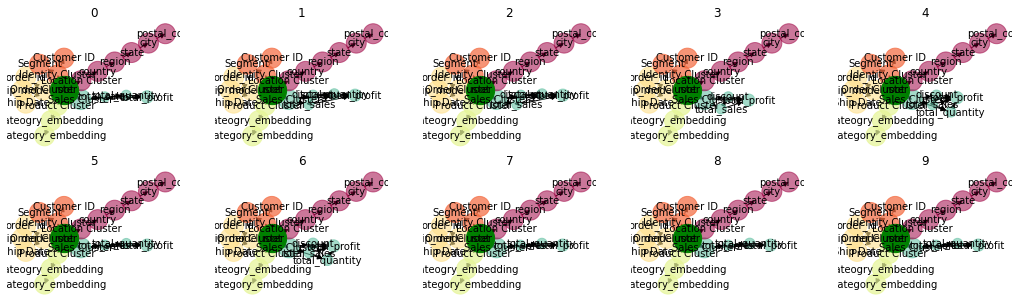

In [7]:
pipeline = RKPipeline(filter_map=filters, linkage_map=linkers, structural_graph=graphs[0])
rkmodels = []
for i, row in df.iterrows():
    g = hft.transform(row)
    g = pipeline.transform(g).get()
    g.id = i
    rkmodels.append(g)
    if i > 10:
        break
distances = compute_distances(rkmodels, mdist, w=[1,0])
visualize_10(rkmodels)
print("Average similarity of graphs pre tuned: {}".format(1 - np.mean(distances)))

### Train the model

In [13]:
import nevergrad as ng
from concurrent import futures
import time

w0 = pipeline.get_w()
    
class ObjectiveFunction():
    
    def __init__(self, pipeline, sample_size):
        self.pipeline = pipeline
        self.sample_size = sample_size
        
    def evaluate(self, w):
        pupdate = self.pipeline.remap(w, w0[1])
        models = []
        sample = df.sample(n=self.sample_size)
        for i, row in sample.iterrows():
            g = hft.transform(row)
            g = pupdate.transform(g).get()
            g.id = i
            models.append(g)
        distances = compute_distances(models, mdist, [1, 0])
        c = 1 - np.mean(distances)
        return c

def train(iterations=3000, batch_size=100):
    loss_history = []
    optimizer = ng.optimizers.NGOpt(parametrization=len(w0[0]), budget=iterations, num_workers=5)
    prev_time = None
    start = time.time()
    ofunc = ObjectiveFunction(pipeline, batch_size)
    for i in range(optimizer.budget):
        x = optimizer.ask()
        loss = ofunc.evaluate(*x.args, **x.kwargs)
        if i % 100 == 0:
            now = time.time()
            if prev_time is not None:
                print("Iteration: {:05d}. Loss: {:.08f}. ITime {:.02f} seconds. Total time: {:.02f}".format(i, loss, now - prev_time, now-start))
            prev_time = now
        loss_history.append(loss)
        optimizer.tell(x, loss)
    
    recommendation = optimizer.provide_recommendation()
    return recommendation.value, loss_history

In [9]:
trained_weights, loss_history = train()

Iteration: 00100. Loss: 0.96121589. ITime 35.60 seconds. Total time: 35.93
Iteration: 00200. Loss: 0.95319971. ITime 36.48 seconds. Total time: 72.41
Iteration: 00300. Loss: 0.97847138. ITime 37.03 seconds. Total time: 109.44
Iteration: 00400. Loss: 0.97949495. ITime 37.10 seconds. Total time: 146.54
Iteration: 00500. Loss: 0.95786646. ITime 36.92 seconds. Total time: 183.46
Iteration: 00600. Loss: 0.97050585. ITime 36.70 seconds. Total time: 220.16
Iteration: 00700. Loss: 0.95996555. ITime 36.77 seconds. Total time: 256.93
Iteration: 00800. Loss: 0.96010225. ITime 36.88 seconds. Total time: 293.81
Iteration: 00900. Loss: 0.95704662. ITime 37.03 seconds. Total time: 330.84
Iteration: 01000. Loss: 0.95633282. ITime 36.88 seconds. Total time: 367.72
Iteration: 01100. Loss: 0.95572867. ITime 36.72 seconds. Total time: 404.45
Iteration: 01200. Loss: 0.95330769. ITime 36.79 seconds. Total time: 441.24
Iteration: 01300. Loss: 0.94409278. ITime 36.80 seconds. Total time: 478.04
Iteration: 014

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


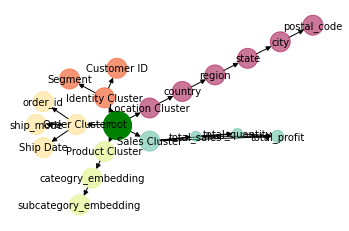

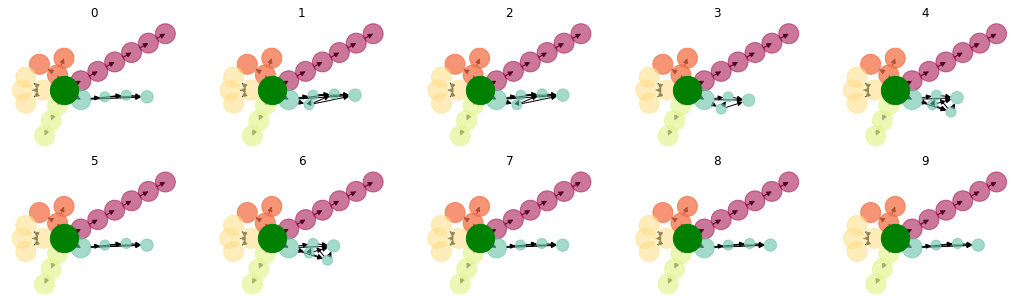

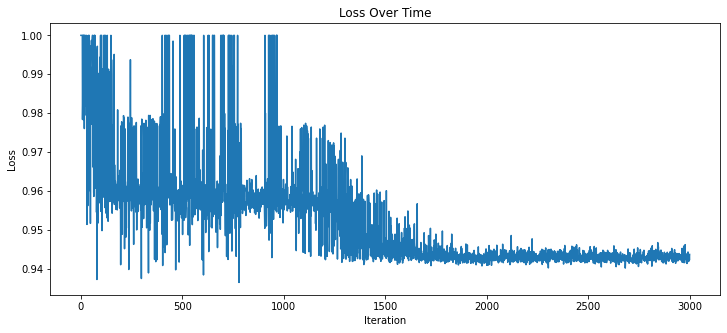

In [10]:
def show(trained_weights, loss_history):
    
    pupdate = pipeline.remap(trained_weights, w0[1])
    for i, row in df.iterrows():
        g = hft.transform(row)
        g = pupdate.transform(g).get()
        g.id = i
        rkmodels.append(g)
        if i > 10:
            break
    distances = compute_distances(rkmodels, mdist, [1, 0])
    draw_g(rkmodels[0], ax=None, with_labels=True, minsize=100, alpha=300, emult=2, make_axis=False)

    visualize_10(rkmodels)
    plt.show()
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_title("Loss Over Time")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.plot(loss_history)
    plt.show()
    
show(trained_weights, loss_history)

In [15]:
trained_weights, loss_history = train(batch_size=100, iterations=1000)

Iteration: 00100. Loss: 0.96374562. ITime 35.29 seconds. Total time: 35.63
Iteration: 00200. Loss: 0.96057039. ITime 37.21 seconds. Total time: 72.85
Iteration: 00300. Loss: 0.95497581. ITime 36.68 seconds. Total time: 109.53
Iteration: 00400. Loss: 0.97164069. ITime 36.93 seconds. Total time: 146.45
Iteration: 00500. Loss: 0.97642136. ITime 36.43 seconds. Total time: 182.88
Iteration: 00600. Loss: 0.93901955. ITime 36.98 seconds. Total time: 219.86
Iteration: 00700. Loss: 0.95087442. ITime 36.90 seconds. Total time: 256.76
Iteration: 00800. Loss: 0.93776269. ITime 37.03 seconds. Total time: 293.79
Iteration: 00900. Loss: 0.94155875. ITime 36.59 seconds. Total time: 330.37


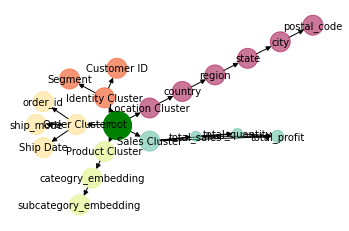

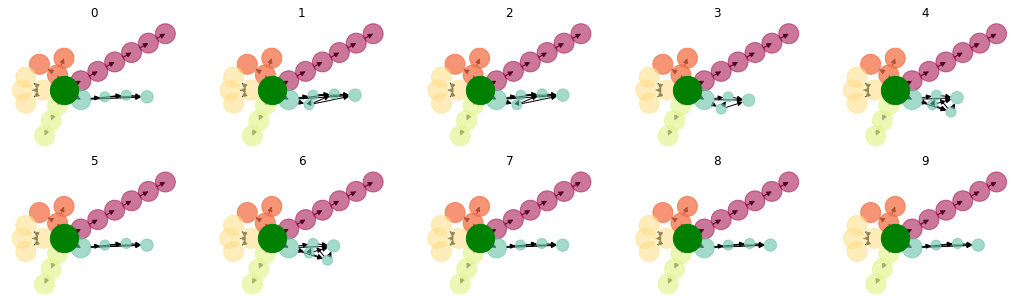

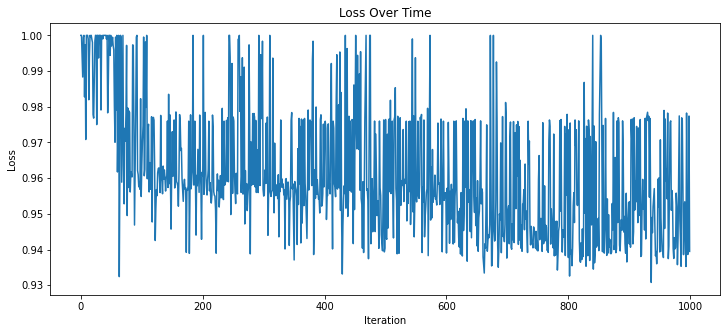

In [16]:
show(trained_weights, loss_history)